In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#**Generative Adversarial Networks(GANs)**

# **A.Generative Adversarial Networks with TensorFlow**

##**1. Import libraries.**

In [ ]:
import numpy as np
import os


import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new!
from tensorflow.keras.optimizers import RMSprop


import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


from zipfile import ZipFile
import os

with ZipFile('/content/drive/MyDrive/GAN-2022/apple.zip','r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/GAN')

##**2. Importing data.**

In [ ]:
input_images = "/content/drive/MyDrive/GAN/apple.npy"

In [ ]:
data = np.load(input_images) #

In [ ]:
data.shape

(144722, 784)

In [ ]:
data[3765]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  13,  60,  78,  92,  13,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  89, 231, 255, 255, 255,  76,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  30, 184, 255, 194,  68,  43,  22,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  12, 213, 238, 100,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 163, 250,  57,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   6,  78, 166, 207, 149,  47, 25

##**3. Scale and reshape the images.**

In [ ]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [ ]:
data[2765]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.03529412],
        [0.39607843],
        [0.01568627],
        [0.        ],
        

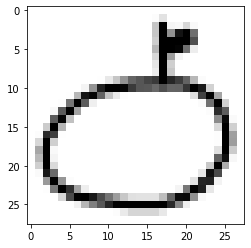

In [ ]:
plt.imshow(data[2654,:,:,0], cmap='Greys')

##**4. Creating the discriminator network.**

In [ ]:
def discriminator_builder(depth=64,p=0.4):


    inputs = Input((img_w,img_h,1))


    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)

    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)

    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)

    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))


    output = Dense(1, activation='sigmoid')(conv4)


    model = Model(inputs=inputs, outputs=output)
    model.summary()

    return model

In [ ]:
discriminator = discriminator_builder()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 dropout_11 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 256)         819456    
                                                                 
 dropout_12 (Dropout)        (None, 4, 4, 256)         0   

##**5. We compile the model.**

In [ ]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                      metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


##**6. Creating the generator network.**

In [ ]:
def generator_builder(z_dim=100,depth=64,p=0.4):


    inputs = Input((z_dim,))


    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)


    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)


    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)


    model = Model(inputs=inputs, outputs=output)
    model.summary()

    return model

In [ ]:
generator = generator_builder()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_9 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization_8 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 3136)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 64)          0         
                                                           

##**7. Creating the adversarial network.**


In [ ]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0),
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
adversarial_model = adversarial_builder()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 28, 28, 1)         396961    
                                                                 
 model_4 (Functional)        (None, 1)                 4311553   
                                                                 
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


##**8. Training.**

In [ ]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [ ]:
def train(epochs=2000,batch=128):

    d_metrics = []
    a_metrics = []

    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):

        if i%100 == 0:
            print(i)

        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0

        make_trainable(discriminator, True)

        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        make_trainable(discriminator, False)

        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

    return a_metrics, d_metrics

##**9. After 100 epochs of training, we have some elementary structures that the generator had learned. After 200 epochs of training, those structures are starting to look a little bit like sketches, and even more so after 300 epochs. And then, after about 1,000 epochs of training, we will have quite a few of these sketches starting to look roughly like apples. Moreover, after 2,000 epochs, many examples are high-quality unreal sketches of apples. Here, we have used 1000 epochs.**

0
100
200
300
400
Epoch #500
499: [D loss: 0.464435, acc: 0.820907]  [A loss: 2.031938, acc: 0.167695]


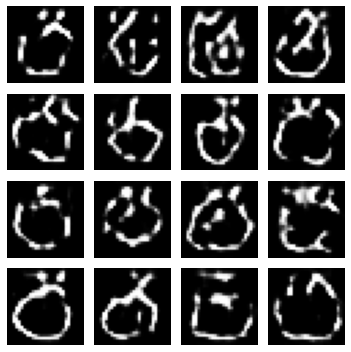

500
600
700
800
900
Epoch #1000
999: [D loss: 0.538404, acc: 0.749159]  [A loss: 1.685164, acc: 0.145450]


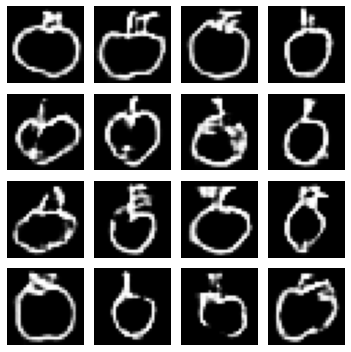

In [ ]:
a_metrics_complete, d_metrics_complete = train(epochs=1000)

##**10.Ploting the training loss for the Generator and Discriminator.**

Text(0, 0.5, 'Loss')

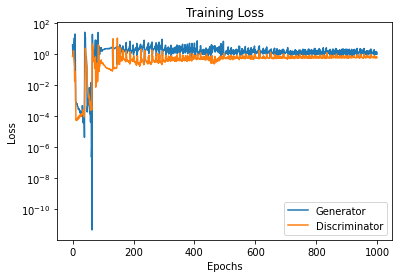

In [ ]:
ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

##**11. Ploting the training accuracy for the Generator and Discriminator.**

Text(0, 0.5, 'Accuracy')

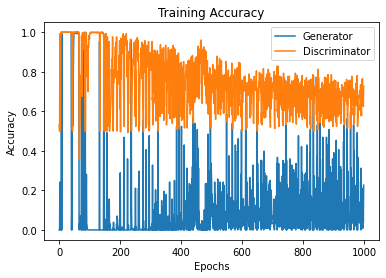

In [ ]:
ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

# **B.Generative Adversarial Networks with Pytorch**

## **1.Import libraries.**

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from IPython.display import clear_output

##**2. We define our Imshow helper function.**

In [ ]:
def imshow(img,size=10):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

##**3. We load our data.**

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=100, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



device(type='cuda')

##**4.We create the Generator Class and Discriminator Class.**

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim=128, output_dim=784):
    super(Generator, self).__init__()
    self.latent_dim = latent_dim
    self.output_dim = output_dim
    self.generator = nn.Sequential(
        nn.Linear(self.latent_dim, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.generator(x)
    x = x.view(-1, 1, 28, 28)
    return x

class Discriminator(nn.Module):
  def __init__(self, input_dim=784, output_dim=1):
    super(Discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.discriminator = nn.Sequential(
      nn.Linear(self.input_dim, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, self.output_dim),
      nn.Sigmoid()
    )

  def forward(self, x):
        x = x.view(-1, 784)
        x = self.discriminator(x)
        return x

##**5. We create the optimizer and loss function.We also need to create some helper functions. The first function noise generates the random noise we input into the generator. The second function, make_ones is a helper to mark the batch as real, with 1s. Then the third function, make_zeros, does the opposite and marks the batch of images with a zero for unauthentic images.**


In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []

loss_fn = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

##**6.Training**

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    loss_real = loss_fn(prediction_real, make_ones(n))
    loss_real.backward()

    prediction_fake = discriminator(fake_data)
    loss_fake = loss_fn(prediction_fake, make_zeros(n))

    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    loss = loss_fn(prediction, make_ones(n))

    loss.backward()
    optimizer.step()

    return loss

Epoch 2: g_loss: 5.70312214 d_loss: 0.58481121


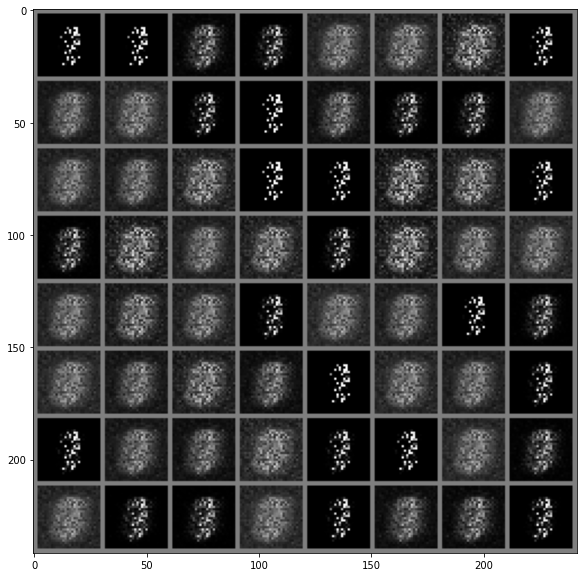

In [ ]:
epochs = 2
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(epochs):
    g_loss = 0.0
    d_loss = 0.0
    for i, data in enumerate(train_loader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    g_losses.append(g_loss/i)
    d_losses.append(d_loss/i)
    clear_output()
    print(f'Epoch {epoch+1}: g_loss: {g_loss/i:.8f} d_loss: {d_loss/i:.8f}')
    imshow(make_grid(img))

**References:**
**[1] Advanced Forecasting with Python: With State-of-the-Art-Models Including LSTMs, Facebook’s Prophet, and Amazon’s DeepAR, Joos Korstanje, July 2021.**
**[2]. Deep Learning: Recurrent Neural Networks with Python, AI Sciences, 2021.**
**[3]. Deep Learning with Applications Using Python : Chatbots and Face, Object, and Speech Recognition With TensorFlow and Keras, Navin Kumar Manaswi, 2018.**
**[4]. Machine Vision, GANs, and Deep Reinforcement Learning, Jon Krohn, 2020.**
**[5]. Generating a New Reality: From Autoencoders and Adversarial Networks to Deepfakes, Micheal Lanham, 2021.**
**[6].Hands-On Mathematics for Deep Learning, Jay Dawani, 2020**
